### Nuißl Sandra, 14.08.2023
## "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen"
### - Implementierung und Evaluierung der Topic Modelling Modelle: LSA -

<hr>

## **Inhaltsverzeichnis**

<ul>1. Aufbau des Jupyter Notebooks</ul>
<ul>2. Instalation und Imports</ul>
    <ul>
     <ul>2.1. Installationen</ul>
     <ul>2.2. Imports</ul>
    </ul>
<ul>3. Laden der bereinigten Amazon Daten</ul>
<ul>4. Implementierung des Modells</ul>
    <ul>
     <ul>4.1. Tokenisierung und Vectorisierung</ul>
     <ul>4.2. Modellierung</ul>
     <ul>4.3. Visualisierung</ul>
    </ul>
<ul>5. Evaluierung</ul>
    <ul>
     <ul>5.1. Coherence score</ul>
     <ul>5.2. Perplexity</ul>
     <ul>5.3. Similarity</ul>
    </ul>
<ul>6. Literaturverzeichnis</ul>
<hr>

## 1. Aufbau des Jupyter Notebooks
Dieses Jupyter Notebook ist Teil der Master Thesis "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen".
Es beinhaltet die Implementierung des Topic Modelling Modells von __LSA__ sowie dessen Evaluierung.

Die theoretischen Inhalte zu diesem Notebook sind der schriftlichen Ausarbeitung dieser Masterarbeit unter den Kapiteln "5. 1.	LSA" und "6.	Empirische Evaluierung der Modelle" zu entnehmen.

## 2. Instalationen und Imports
### 2.1. Installationen

In [ ]:
# Instalationen
%pip install nltk
%pip install tables
%pip install dash
%pip install jupyter_dash
%pip install gitly==1.0.1
%pip install plotly>4.0.0
%pip install umap-learn

### 2.2. Imports

In [2]:
# Imports und Initalisierungen
import numpy as np
import pandas as pd
import tables
import warnings
warnings.filterwarnings('ignore')

# Beschleunigung
import joblib
from joblib import Parallel, delayed

# Progressbar
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from tqdm.auto import tqdm
tqdm_notebook.pandas()

# Datenvisualisierung
import plotly.express as px
import plotly.figure_factory as ff
import dash
from dash import Dash, callback
from dash import dash_table
from dash import dcc
from jupyter_dash import JupyterDash
from dash import html
from dash.dependencies import Output, Input, State
from gitly.colab.plot import GitlyPlotter
gitly = GitlyPlotter('github')                                       # Instanziierung des Objekts

# Benötiget für die Topic Modelling Modelle
from sklearn.feature_extraction.text import TfidfVectorizer          # TFidf Vectorisierung
from sklearn.decomposition import TruncatedSVD                       # Dimensionsreduktion
import nltk
from nltk.tokenize import RegexpTokenizer                            # Token
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')                           # Definition eines neuen Tokenizer

# Evaluierung
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

There are few libs and modules that should be installed in Colab in order to generate static plots from Plotly.
Summary: Install Orca, update plotly and update apt-get

apt-get update
pip install plotly>=4.0.0
wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
chmod +x /usr/local/bin/orca
apt-get install xvfb libgtk2.0-0 libgconf-2-4
Done. Have fun! :)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Laden der bereinigten Amazon Daten

In [4]:
# Review Daten laden
reviews_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/Master_Backup/Cleaned_Sport_and_Outdoors.h5')

# Ausgabe
pd.concat([reviews_df], axis=1, sort = False, keys = ["Bereinigter Datensatz: Sport and Outdoors"])

Bereinigter Datensatz: Sport and Outdoors  \
                                                reviewText   
0                  What a spectacular tutu! Very slimming.   
1        What the heck? Is this a tutu for nuns? I know...   
2                        Exactly what we were looking for!   
3        I used this skirt for a Halloween costume and ...   
4        This is thick enough that you can't see throug...   
...                                                    ...   
2264636                     Wife laughs at me but it works   
2264637  2XU makes great compression shorts. A bit more...   
2264638  These are my favorite compression shorts for r...   
2264639  Love the shorts.. amazing comfortable, perfect...   
2264640  I have a briley bolt release paddle installed ...   

                                                                          \
                                               cleanedText  year overall   
0                               spectacular tutu veri slim  2015     5.0   
1        heck tutu nun know cut still also nt sever lay...  2015     1.0   
2                                               exact look  2015     5.0   
3        use skirt halloween costum glue bunch feather ...  2014     5.0   
4        thick enough ca nt see veri long sure check di...  2014     4.0   
...                                                    ...   ...     ...   
2264636                                    wife laugh work  2018     4.0   
2264637  xu make great compress short bit expens well w...  2018     5.0   
2264638  favorit compress short run thinnest materi run...  2018     5.0   
2264639  love short amaz comfort perfect compress perfe...  2018     5.0   
2264640  briley bolt releas paddl instal a xplor sport ...  2017     5.0   

                                                                      \
            brand                                              title   
0        BubuBibi                           Adult Ballet Tutu Yellow   
1        BubuBibi                           Adult Ballet Tutu Yellow   
2        BubuBibi                           Adult Ballet Tutu Yellow   
3        BubuBibi                           Adult Ballet Tutu Yellow   
4        BubuBibi                           Adult Ballet Tutu Yellow   
...           ...                                                ...   
2264636  Columbia                               Columbia Bora booney   
2264637       2XU                  2XU Men's Core Compression Shorts   
2264638       2XU                  2XU Men's Core Compression Shorts   
2264639       2XU                  2XU Men's Core Compression Shorts   
2264640       STS  T&amp;s Shell Catcher Beretta A400 Multitarget...   

                     
               asin  
0        0000032034  
1        0000032034  
2        0000032034  
3        0000032034  
4        0000032034  
...             ...  
2264636  B01HJDZ34I  
2264637  B01HJGAJ9O  
2264638  B01HJGAJ9O  
2264639  B01HJGAJ9O  
2264640  B01HJHHBHG  

[2264641 rows x 7 columns]

#### __Verleinerung des Datensatzes__
LSA ist in der Lage größere Datenmengen zu verarbeiten. Da aber aus Kapazitätsgründen der Datensatz für andere Modelle verkeleinert werden musste, wird für alle Topic Modelling Modelle der gleiche Datensatz verwendet. Dadurch können die Ergebnisse der Evaluierung besser verglichen werden.

In [5]:
# Verleinerung des Datensatzes Aufgrund der Performence
reviews_df = reviews_df.iloc[ :100000,]

## 4. Implementierung des Modells

### 4.1. Tokenisierung und Vectorisierung

Mithilfe des TF - IDF Vectorizers werden die langkettigen strings des bereinigten Datensatzes in Token zerlegt, welche von dem Machine Learning Model verarbeitet werden können (Ioana, 2020). Das Ergebnis ist eine Wort - Dokumeten - Matrix, welche in den Spalten die Worte und in den Zeilen die Dokumente abbildet. Die Zahlen in den Zellen repräsentieren die Wahrscheinlichkeiten der Wörter pro Dokument.

In [6]:
# Initialisierung des TF-IDF-Vektoriesers
# Quelle: https://github.com/Ioana-P/pca_and_clustering_for_edu_purposes/blob/master/newsgroups_LSA.ipynb
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, min_df=0.05)

In [7]:
# Vektorisierung der Amazon Daten mithilfe des TF-IDF-Vektoriser
# Quelle: https://github.com/Ioana-P/pca_and_clustering_for_edu_purposes/blob/master/newsgroups_LSA.ipynb
# Quelle (Lösung zur Fehlermeldung): https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
text_vec = vectorizer.fit_transform(reviews_df["cleanedText"])

# Erstellung der Wort - Dokumenten - Matrix
word_doc_matrix = text_vec.toarray()

# Speichern in einen DataFrame
word_doc_matrix_df = pd.DataFrame(word_doc_matrix,
                                  columns=vectorizer.get_feature_names_out())

# Ausgabe
word_doc_matrix_df

,also,ani,back,becaus,better,bike,buy,come,could,day,...,time,tri,use,veri,want,way,well,work,would,year
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.512272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.231818,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.431486,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
99996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
99997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.669943,0.0,0.0,0.0
99998,0.283495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.175608,0.205310,0.0,0.0,0.216266,0.0,0.0,0.0


### 4.2. Modellierung
#### __Initialisierung des Modells__

Nach der Vektorisierung wird die Dimensionsreduktion und das Clustering mithilfe der Singulärwertzerlegung (SVD) durchgeführt. Es kann zwischen der vollständigen SVD, welche die gesamte Varianz eines Datensatzes abbildet, und der abgeschnittenen SVD gewählt werden. Bei Letzterer lässt sich die Anzahl der endgültigen Komponenten festgelegt, um mit reduzierten Merkmalen die Daten relativ gut zu abzubilden. Aus diesem Grund wird im Rahmen dieser Masterarbeit die Klasse „TruncatedSVD“ von sklearn initialisiert. Über den Parameter „n_iter“ können die Anzahl der Merkmale beschränkt werden und mithilfe von „n_components“ ist festzulegen, wie viele Themen das Modell bilden soll (Ioana, 2020).


In [8]:
# Dimensionsreduktion (abgeschnittene SVD)
# Quelle: https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8
lsa_model = TruncatedSVD(n_components=10, n_iter=100, random_state=42)

#### __Anwendung auf den Datensatz__
Mithilfe der Funktion "fit_transform()" wird die zufor initialisierte Klasse auf die Vektorisierten Daten des Amazon Datensatzes angewendet, woraus sich eine __Topic - Dokumenten - Matrix__, __Topic - Wort - Matrix__ und die __Singularitätsmatrix__eine ergibt.

In [9]:
# Anwendung des Topic Modelling Models auf den Datensatz
# Quelle: https://github.com/Ioana-P/pca_and_clustering_for_edu_purposes/blob/master/newsgroups_LSA.ipynb
lsa_topic = lsa_model.fit_transform(text_vec)

### 4.3. Visualisierung

#### __Topic - Dokumenten - Matrix__

Die Zeilen bilden die Vektordarstellung der Dokumenta ab, während die Länge des Vektors die Anzahl der Topics anzeigt (MEHROTRA, 2022). Die Spalten bilden die Wahrscheinlichkeiten der Topics für ein Dokument ab, welche mithilfe des interaktiven Dashboards für die Reviews angezeigt werden können. (Für eine höhere Aussagekraft der Topics können die häufigsten Wörter je Topic in der Topic - Wort - Matric weiter unten entnommen werden)

In [ ]:
# Dimensionen der Dokumenten - Topic - Matrix
# Quelle: https://github.com/Ioana-P/pca_and_clustering_for_edu_purposes/blob/master/newsgroups_LSA.ipynb
print(f"Die Dokumenten - Topic - Matrix umfasst {lsa_topic.shape[1]} Topics in {lsa_topic.shape[0]} Reviews.")

Die Dokumenten - Topic - Matrix umfasst 10 Topics in 100000 Reviews.


In [ ]:
# Initialisierung der App (Inline)
# Quelle: https://towardsdatascience.com/are-you-still-creating-boring-static-plots-its-time-to-move-on-384f49b60d16
# Quelle: https://dash.plotly.com/dash-in-jupyter
app = dash.Dash(suppress_callback_exceptions=True, title= "Probability Reviews",
                meta_tags=[{'name': 'viewport', 'content': 'width=device-width, initial-scale=1.0'}]
                )

# Layout
app.layout = html.Div([
    html.H3(id = 'select_brand', children = 'Wähle sie eine Reviewnummer aus:', style={"font-family": "Microsoft Yi Baiti"}),

    # Erstellung des Dropdownmenues
    dcc.Dropdown(
                options = [{'label': str(i), 'value': i} for i in range(len(lsa_topic))],
                value = 300,
                id='input_review',
                clearable=False,
                style={"font-family": "Microsoft Yi Baiti"},
                ),

    dcc.Graph(id='topic_probability_fig'),

], style={"font-family": "Microsoft Yi Baiti", "background-color": "#FFFFFF"}
)


# Initialisierung des Callbacks
@app.callback(Output(component_id='topic_probability_fig', component_property='figure'),
              [Input(component_id='input_review', component_property='value')])

def topic_probability_fig(review_number):
    # Wahrscheinlichkeiten der Topics pro Dokument
    # Quelle: https://github.com/rollyjohn/Topic-Modelling/blob/main/topic_model_V3.ipynb
    review_number = int(review_number)
    topic_probability = lsa_topic[review_number]

    # Erstellen eines DataFrames
    topic_probability_df = pd.DataFrame(topic_probability, columns= ["pobabilities"])

    # Umrechnen der Wahrscheinlichkeiten in %
    topic_probability_df = topic_probability_df.assign(pobabilities_percent=lambda x: round(x.pobabilities * 100))

    # Hinzufügen einer Spalte mit den Topics (Numerisch)
    topic_probability_df = topic_probability_df.assign(topic=lambda x: x.index + 1)
    topic_probability_df["topic"] = topic_probability_df.topic.astype(str)

    # Plot
    topic_probability_fig = px.bar( topic_probability_df, x="topic", y="pobabilities_percent", title="Wahrscheinlichkeit der Topics pro Review: Sports and Outdoors", text_auto='.2s',
                                    color_discrete_sequence=px.colors.sequential.Darkmint_r)
    topic_probability_fig.update_xaxes(title_text= "Topics")
    topic_probability_fig.update_yaxes(title_text= "Wahrscheinlichkeit (in %)")
    return topic_probability_fig

# Laufen des Servers
if __name__ == '__main__':
    app.run(jupyter_mode="inline")

<IPython.core.display.Javascript object>

Über diese Wahrscheinlichkeiten lassen sich die dominante Topics des Amazon Datensatzes ermitteln. Hierfür wurden das Topic mit der höchsten Wahrscheinlichkeit pro Review in einer Liste gespeichert, welche anschließen gruppiert und gezählt wird.

In [10]:
# Definition einer Funktion zur Ermittlung der Dominanten Topics
# Quelle: https://github.com/rollyjohn/Topic-Modelling/blob/main/topic_model_V3.ipynb
def got_dominace_topic(review):
    range_number = [1,2,3,4,5,6,7,8,9,10]
    topic_probability = review
    dominant_df = pd.DataFrame(data=np.column_stack((range_number,topic_probability)),columns=['Topic_number','Probability'])

    # Absteigendes Sortieren der Wahrscheinlichkeiten
    dominant_df.sort_values(by=['Probability'], ascending=False, inplace=True)
    dominant_df.reset_index(inplace=True, drop=True)
    dominace_topic = dominant_df.Topic_number[1]
    return dominace_topic

In [11]:
# Anwenden der Funktion
dominance_list = Parallel(n_jobs=-1)(delayed(got_dominace_topic)(review) for review in tqdm(lsa_topic, desc ="Status der geladenen Zeilen: ", total = len(lsa_topic)))

# Speichern der Ergebnisse in einen DataFrame
dominance_df = pd.DataFrame(dominance_list, columns=["Topic_number"])

# Gruppieren und Zählen der Topics
dominance_topics_df = dominance_df.groupby(['Topic_number']).size()
dominance_topics_df = dominance_topics_df.to_frame(name='count').reset_index()
dominance_topics_df["Topic_number"] = dominance_topics_df.Topic_number.astype(int).astype(str)

Status der geladenen Zeilen:   0%|          | 0/100000 [00:00<?, ?it/s]

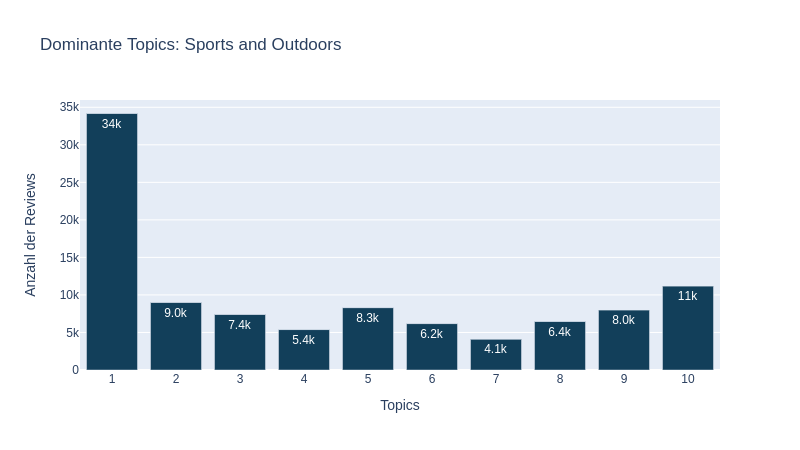

In [ ]:
# Graphische Darstellung
topic_probability_fig = px.bar(dominance_topics_df, x="Topic_number", y="count", title="Dominante Topics: Sports and Outdoors", text_auto='.2s',
                      color_discrete_sequence=px.colors.sequential.Darkmint_r)
topic_probability_fig.update_xaxes(title_text= "Topics")
topic_probability_fig.update_yaxes(title_text= "Anzahl der Reviews")

# Speichern in ein HTML File
topic_probability_fig.write_html("LSA_Dominant_Topics.html")

# Ausgabe
gitly.show(topic_probability_fig)

#### __Topic - Wort - Matrix__
Des Weiteren wird die __Topic - Wort - Matrix__ erzeugt, welche die Vektordatstellug der Wörter abbildet (MEHROTRA, 2022). Jedes Topic wird hierbei durch eine Auswahl von Wörtern repräsentiert, mithilfe dessen den Topics durch den Menschen ein Überbegriff zugeordnet werden kann.

In [12]:
# Ausgabe der Topic - Wort - Matrix
# Quelle: https://github.com/Ioana-P/pca_and_clustering_for_edu_purposes/blob/master/newsgroups_LSA.ipynb
topic_word_matrix = lsa_model.components_
print(f"Die Topic - Wort - Matrix umfasst {topic_word_matrix.shape[0]} Topics mit insgesammt {topic_word_matrix.shape[1]} Wörtern.")

# Wichtigste Wörter je Topic
# Quelle: https://github.com/rollyjohn/Topic-Modelling/blob/main/topic_model_V3.ipynb
# Erstellung eines Wörterbuchs
dictionray_word = vectorizer.get_feature_names_out()

# Erzeugen eines DataFrames
topic_numbers = [1,2,3,4,5,6,7,8,9,10]
topics_df = pd.DataFrame(topic_numbers, columns=["Topic_number"])
topics_df =  topics_df.assign(Words = "", Probabilities = "")


# Ermittlung der Top 10 Wörter der 10 Topics
words_list = []
probabilities_list = []
for i, comp in enumerate(topic_word_matrix):
    vocab_comp = zip(dictionray_word, comp)
    sorted_words = sorted(vocab_comp, key= lambda x: x[1], reverse=True)[:10]
    # Extraktion der Wörter
    words = []
    for content in sorted_words:
        word = content[0]
        words.append(word)
    words_list.append(words)
    # Extraktion der Wahrscheinlichkeiten
    probabilities = []
    for content in sorted_words:
        probabilitie = round(content[1], 4)
        probabilities.append(probabilitie)
    probabilities_list.append(probabilities)
# Hinzufügen der Ergebnisse in den DataFrame
topics_df["Words"] = words_list
topics_df["Probabilities"] = probabilities_list
topics_df["Topic_number"] = topics_df.Topic_number.astype(str)

# Ausgabe
topics_df.style.set_properties(subset=['Words'], **{'width': '300px'})

Die Topic - Wort - Matrix umfasst 10 Topics mit insgesammt 60 Wörtern.


,Topic_number,Words,Probabilities
0,1,"['use', 'great', 'work', 'veri', 'good', 'get', 'one', 'well', 'buy', 'like']","[0.3475, 0.3369, 0.2563, 0.2324, 0.2272, 0.218, 0.2096, 0.1952, 0.1735, 0.1733]"
1,2,"['great', 'work', 'price', 'product', 'love', 'fit', 'qualiti', 'high', 'perfect', 'look']","[0.86, 0.231, 0.079, 0.0651, 0.0031, -0.0028, -0.0098, -0.0108, -0.0117, -0.0159]"
2,3,"['good', 'qualiti', 'veri', 'price', 'fit', 'product', 'nice', 'look', 'size', 'great']","[0.6953, 0.2204, 0.2126, 0.2018, 0.1393, 0.1269, 0.1002, 0.0616, 0.0353, 0.0259]"
3,4,"['work', 'well', 'veri', 'good', 'make', 'seem', 'hold', 'fit', 'bike', 'perfect']","[0.7535, 0.4, 0.1333, 0.1008, 0.0389, 0.0196, 0.0167, 0.0109, 0.0064, 0.0052]"
4,5,"['use', 'good', 'product', 'qualiti', 'price', 'great', 'easi', 'time', 'year', 'high']","[0.6789, 0.4296, 0.1095, 0.0746, 0.0679, 0.0515, 0.0511, 0.0211, -0.0047, -0.0089]"
5,6,"['veri', 'nice', 'use', 'well', 'easi', 'love', 'make', 'fit', 'great', 'hold']","[0.7192, 0.1957, 0.1601, 0.1578, 0.1502, 0.1054, 0.0873, 0.0794, 0.0464, 0.03]"
6,7,"['love', 'work', 'good', 'perfect', 'use', 'buy', 'year', 'well', 'fit', 'easi']","[0.8989, 0.1789, 0.1372, 0.1061, 0.0612, 0.0578, 0.0479, 0.0457, 0.0224, 0.0217]"
7,8,"['fit', 'perfect', 'use', 'size', 'nice', 'well', 'like', 'small', 'look', 'need']","[0.6666, 0.4526, 0.188, 0.1561, 0.1088, 0.0578, 0.0574, 0.0549, 0.0539, 0.035]"
8,9,"['get', 'veri', 'love', 'good', 'nice', 'littl', 'great', 'easi', 'fit', 'take']","[0.7039, 0.0979, 0.0881, 0.0847, 0.0818, 0.0737, 0.0496, 0.0489, 0.0485, 0.0442]"
9,10,"['make', 'well', 'product', 'like', 'realli', 'love', 'would', 'hold', 'seem', 'look']","[0.4456, 0.3623, 0.3369, 0.2853, 0.1033, 0.099, 0.065, 0.0644, 0.0597, 0.0588]"


#### __Singularitätswert__

Der Singularitätswert sind sogenannte Eigenvalues und bildet die Rangfolge der Topics ab. Das erste Topic erhält den höchsten Rang und verläuft dann absteigend. Die Anzahl der Singularitätswert wird durch die Anzahl der gewünschten Topics definert (pawangfg, 2023).

In [13]:
# Ausgabe des Singularitätswertes
# Quelle: https://github.com/Ioana-P/pca_and_clustering_for_edu_purposes/blob/master/newsgroups_LSA.ipynb
Sigma = lsa_model.singular_values_
topics_df =  topics_df.assign(Sigma = Sigma)
print(f"Der Singularitätswert (Sigma) beträgt {Sigma.shape[0]}")

# Ausgabe
topics_df.style.set_properties(subset=['Words'], **{'width': '300px'})

Der Singularitätswert (Sigma) beträgt 10


,Topic_number,Words,Probabilities,Sigma
0,1,"['use', 'great', 'work', 'veri', 'good', 'get', 'one', 'well', 'buy', 'like']","[0.3475, 0.3369, 0.2563, 0.2324, 0.2272, 0.218, 0.2096, 0.1952, 0.1735, 0.1733]",104.208402
1,2,"['great', 'work', 'price', 'product', 'love', 'fit', 'qualiti', 'high', 'perfect', 'look']","[0.86, 0.231, 0.079, 0.0651, 0.0031, -0.0028, -0.0098, -0.0108, -0.0117, -0.0159]",65.043916
2,3,"['good', 'qualiti', 'veri', 'price', 'fit', 'product', 'nice', 'look', 'size', 'great']","[0.6953, 0.2204, 0.2126, 0.2018, 0.1393, 0.1269, 0.1002, 0.0616, 0.0353, 0.0259]",58.296803
3,4,"['work', 'well', 'veri', 'good', 'make', 'seem', 'hold', 'fit', 'bike', 'perfect']","[0.7535, 0.4, 0.1333, 0.1008, 0.0389, 0.0196, 0.0167, 0.0109, 0.0064, 0.0052]",54.904430
4,5,"['use', 'good', 'product', 'qualiti', 'price', 'great', 'easi', 'time', 'year', 'high']","[0.6789, 0.4296, 0.1095, 0.0746, 0.0679, 0.0515, 0.0511, 0.0211, -0.0047, -0.0089]",54.451361
5,6,"['veri', 'nice', 'use', 'well', 'easi', 'love', 'make', 'fit', 'great', 'hold']","[0.7192, 0.1957, 0.1601, 0.1578, 0.1502, 0.1054, 0.0873, 0.0794, 0.0464, 0.03]",52.635217
6,7,"['love', 'work', 'good', 'perfect', 'use', 'buy', 'year', 'well', 'fit', 'easi']","[0.8989, 0.1789, 0.1372, 0.1061, 0.0612, 0.0578, 0.0479, 0.0457, 0.0224, 0.0217]",50.071924
7,8,"['fit', 'perfect', 'use', 'size', 'nice', 'well', 'like', 'small', 'look', 'need']","[0.6666, 0.4526, 0.188, 0.1561, 0.1088, 0.0578, 0.0574, 0.0549, 0.0539, 0.035]",49.112923
8,9,"['get', 'veri', 'love', 'good', 'nice', 'littl', 'great', 'easi', 'fit', 'take']","[0.7039, 0.0979, 0.0881, 0.0847, 0.0818, 0.0737, 0.0496, 0.0489, 0.0485, 0.0442]",47.353831
9,10,"['make', 'well', 'product', 'like', 'realli', 'love', 'would', 'hold', 'seem', 'look']","[0.4456, 0.3623, 0.3369, 0.2853, 0.1033, 0.099, 0.065, 0.0644, 0.0597, 0.0588]",46.303840


## 5. Evaluierung

Um die Topic Modelling Modelle bewerten zu können, ist es wichtig geeignete Metriken und Validierungsmöglichkeiten heranzuziehen. Auf diese Weise lässt sich herausfinden wie gut die Themenklassifizierung funktioniert hat (Pascual, Topic Modeling: An Introduction, 2019). Im Allgemeinen lassen sich zwei verschiedenen Herangehensweisen unterscheiden: die Intrinsische und die extrinsische Clustervalidität.Im Rahmen dieser Masterarbeit wird auf intrinsische Clustervaliditätsmetriken zurückgegriffen, welche strukturelle Eigenschaften der Cluster berücksichtigt und semantische Merkmale vergleichen (Rüdiger, Antons, Joshi, & Salge, 2022).

Befor mit der Anwendung der Evaluierungsmetriken begonnen werden kann, müssen die notwendigen Parameter dafür erzeugt werden.

In [14]:
# Vorverarbeitungsschritte für die Paramtert der Evaluierungsmodelle
# Quelle: https://www.theanalyticslab.nl/topic-modeling-with-bertopic/
# Erstellen einer Liste mit den bereinigten Review Daten
text_list = reviews_df["cleanedText"]

# Erstellen einer Liste mit dem dominanten Topic pro Review
topics = dominance_df.Topic_number.astype(int).to_list()

# Erzeugen eines DataFrames mit den relevanten Informationen
documents_df = pd.DataFrame({"Document": text_list,
                             "ID": range(len(text_list)),
                             "Topic_number": topics})

# Gruppieren der Dokumente je Topic
documents_per_topic = documents_df.groupby(['Topic_number'], as_index=False).agg({'Document': ' '.join})

# Bilden einer Liste aller Sätze pro Topic
cleaned_docs = documents_per_topic.Document.to_list()

In [15]:
# Bildung eines Analyzers mithilfe des im Modelling verwendeten Vektorisers
# Quelle: https://www.theanalyticslab.nl/topic-modeling-with-bertopic/
analyzer = vectorizer.build_analyzer()

# Ausgabe des Vektorizer
print(f'Für das Topic Modelling Model von LSA wurde der {vectorizer} verwendet.')

Für das Topic Modelling Model von LSA wurde der TfidfVectorizer(min_df=0.05,
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\b\\w{3,}\\b', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>) verwendet.


In [16]:
# Vorbereitung der Parameter für den Kohärenzscore
# Quelle: https://www.theanalyticslab.nl/topic-modeling-with-bertopic/
# Selection der Featurenames
words = vectorizer.get_feature_names_out()

# Bildung der Parameter für die Evaluierung
token_list = [analyzer(doc) for doc in cleaned_docs]                # Extraktion der Tokens mithilfe des Analysers
dictionary = corpora.Dictionary(token_list)                         # Erstellung des Wörterbuchs aus den Token
corpus = [dictionary.doc2bow(token) for token in token_list]        # Erstellung des BoW Korpus mithilfe der Token und des Dictionaries
topic_list = topics_df.Words.to_list()                              # Erstellen einer Liste mit den wichtigsten Wörtern des Topics

### 5.1.1. Coherence Score
Die Kohärenz bezieht sich auf die semitische Verbundenheit der Wörtern, wodurch Sinnbeziehungen in einem Text entstehen, was auf den Leser semantisch konsistent und logisch wirkt (Rüdiger, Antons, Joshi, & Salge, 2022). Verallgemeinert gesagt ist eine Aussage kohärent, wenn sich die Inhalte gegenseitig stützen (Kapadia, 2019).



#### __Durchschnittlicher Coherence Score des Modells__

Wie bereits in der theoretischen Ausarbeitung dieser Masterarbeit beschrieben, stellt der Kohärenzscore eines Modells die aggregierten Themenkohärenzen der einzelnen Topics dar und gibt Aufschluss darüber wie gut das Modell die Sinnbeziehungen der gesammten Reviews erkannt und geclustert hat. Das Ergebnis kann zwischen 0 und 1 liegen und je mehr dieses sich der 1 annähert, desto höher ist die semantische Verbundeheit der Wörter und Themen (Pedro, 2022).

In [ ]:
# Initialisierung des Kohärenzmodells
coherence_model = CoherenceModel(topics=topic_list,
                                 texts=token_list,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')

# Ermittlung des Kohärenzscores
coherence = coherence_model.get_coherence()

# Ausgabe
print('Coherence Score von LSA beträgt: ', coherence)

Coherence Score von LSA beträgt:  0.38595680554088163


#### __Themenkohärenz__

Mithilfe von Themenkohärenzmaße lässt sich die Ähnlichkeit der Wörter in Bezug auf ein bestimmtes Thema messen (Kapadia, 2019). Auf diese Weise können die Topics identifiziert werden, welche semantisch schlüssig interpretiert werden können.
Hier gilt ebenfalls: Je höher der Score, desto höher die Ähnlichkeit der Wörter im Cluster.

In [ ]:
# Kohärenz Score pro Topic ermitteln
coherence_per_topic = coherence_model.get_coherence_per_topic()

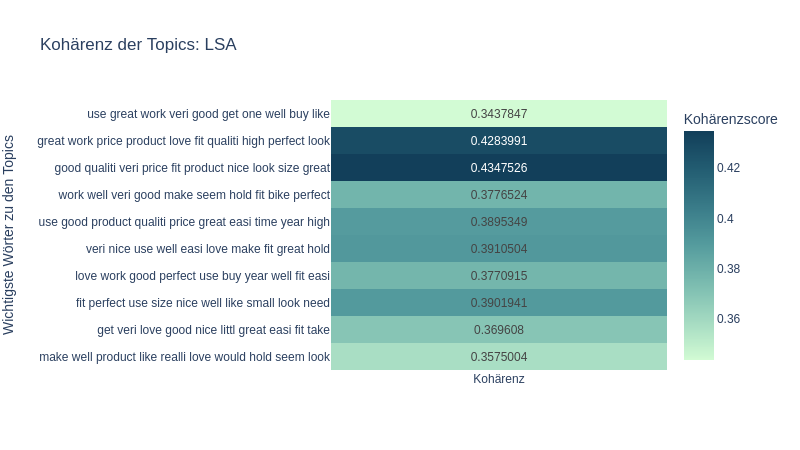

In [ ]:
# Graphische Darstellung
# Speichern der Themenkohörenz und der Topics in einem DataFrame
score_per_topic_df = pd.DataFrame( data=zip(topic_list, coherence_per_topic), columns=['Topic', 'Kohärenz'])

# Umwandeln der Topics in einen string
for index, row in score_per_topic_df.iterrows():
  score_per_topic_df.at[index,"Topic"] = " ".join(row.Topic)

# Setzten des der Liste von Wörter (der Topics) als Index
score_per_topic_df = score_per_topic_df.set_index('Topic')

# Darstellung der Themenkohärenz in einer Heatmap
fig_topic_coherence = px.imshow(score_per_topic_df, text_auto=True, aspect="auto", color_continuous_scale=px.colors.sequential.Darkmint, title = "Kohärenz der Topics: LSA",
                                labels = dict(color = "Kohärenzscore", y = "Wichtigste Wörter zu den Topics"), height = 600, width = 700)


# Speichern in einem HTML File
fig_topic_coherence.write_html("LSA_Coherence.html")

# Ausgabe
gitly.show(fig_topic_coherence)

#### __Ermittlung der idealen Anzahl von Themen__

Für das Maschine Learning Model LSA muss die gewünschte
Anzahl von Topics im Vorhinein eingegeben. Mithilfe des Kohärenzscore ist es möglich die ideale Anzahl der Topics zu ermitteln. Hierfür wird eine Funktion definiert, in welcher die Modellierung, sowie die Ermittlung des aggregierten Kohärenz Scores für die gewünschte Range von möglichem Topic – Anzahlen iteriert wird. Die Anzahl von Topics, welche den höchsten Kohärenzscore ergeben, bildet den optimalen Parameter für das Modell (Kapadia, 2019)

In [ ]:
# Definition einer Funktion, um die Kohärenzwerte mit unterschiedlichen Anzahlen von Topics zu ermitteln
# Quelle: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def compute_coherence_values(vectorizer, dictionary, corpus, docs, token, limit, start=2, step=2):

    # Erstellen einer leeren Liste und eines DataFrames für die zu ermittelnden Kohärenzscores
    coherence_values = []
    topic_amount = range(start, limit, step)
    coherence_df = pd.DataFrame(topic_amount, columns=["Amount_number"])
    coherence_df["Coherencescore"] = ""

    # Loop zur durchführung der Topic Modelling Modelle mit unterschiedlichen Anzahlen von Topics
    for num_topics in range(start, limit, step):
        # Initialisierung und Anwendung des Topic Modelling Modells
        lsa_model = TruncatedSVD(n_components=num_topics, n_iter=100, random_state=42)
        lsa_topic = lsa_model.fit_transform(docs)

        # Ermittlung der ichtigste Wörter je Topic
        # Quelle: https://github.com/Ioana-P/pca_and_clustering_for_edu_purposes/blob/master/newsgroups_LSA.ipynb

        # Erstellung der Topic-Wort Matix und des Wörterbuchs
        topic_word_matrix = lsa_model.components_
        dictionary_word = vectorizer.get_feature_names_out()

        # Ermittlung der Top 10 Wörter der 10 Topics
        words_list = []
        for i, comp in enumerate(topic_word_matrix):
            vocab_comp = zip(dictionary_word, comp)
            sorted_words = sorted(vocab_comp, key=lambda x: x[1], reverse=True)[:10]
            # Extraktion der Wörter und Hinzufügen der Ergebnisse in die Liste der Topics
            words = [content[0] for content in sorted_words]
            words_list.append(words)

        # Initialisierung des Kohärenzmodells
        coherence_model = CoherenceModel(topics=words_list,
                                         texts=token,
                                         corpus=corpus,
                                         dictionary=dictionary,
                                         coherence='c_v')
        # Ermittlung des Durchschnittlichen Kohärenzscores
        coherence_values.append(coherence_model.get_coherence())

    # Sammeln der Kohärenzscores in einen DataFrame
    coherence_df["Coherencescore"] = coherence_values

    return coherence_df


In [ ]:
# Anwendung der Funktion zur Ermittlung der Kohärenz scores
# Quelle: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# Definition der Variablen
limit=20
start=2
step=1

# Anwenden der Funktion
coherence_df = compute_coherence_values(dictionary = dictionary,
                                        vectorizer = vectorizer,
                                        corpus = corpus,
                                        docs = text_vec,
                                        token = token_list,
                                        start = start, limit = limit, step = step)

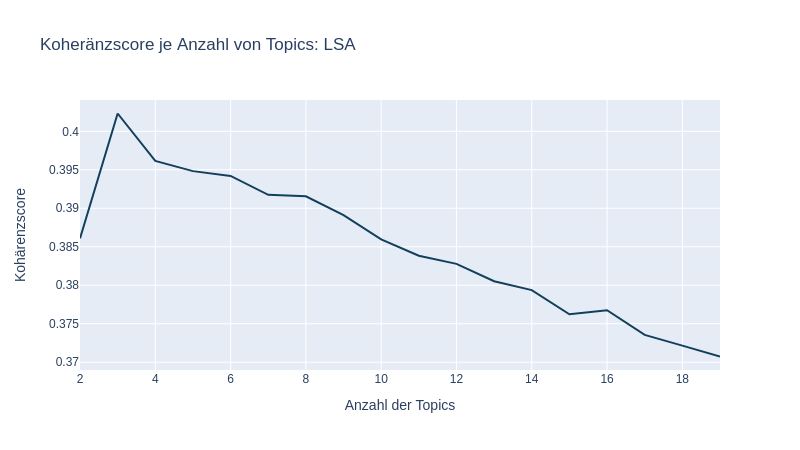

In [ ]:
# Graphische Darstellung
best_coherence_fig = px.line(coherence_df, x="Amount_number", y="Coherencescore",
                             title="Koheränzscore je Anzahl von Topics: LSA",
                             color_discrete_sequence=px.colors.sequential.Darkmint_r)

# Update der Achsen
best_coherence_fig.update_xaxes(title_text= "Anzahl der Topics")
best_coherence_fig.update_yaxes(title_text= "Kohärenzscore")

# Speichern in einem HTML File
best_coherence_fig.write_html("LSA_Best_Coherence.html")

# Ausgabe
gitly.show(best_coherence_fig)

### 5.1.2. Perplexity

Die Perplexity gibt Aufschluss darüber wie gut ein Modell neue Daten verallgemeinern und vorhersagen kann, indem es den Abstand der Themenverteilung des Modells und der gleichmäßigen Wortverteilung des erstellten Wörterbuches misst (Rüdiger, Antons, Joshi, & Salge, 2022). Ein Modell hat ein „gutes Verständnis“ über eine Sprache, wenn es ein semantisch korrektes und häufig auftretendes Wort eine hohe Wahrscheinlichkeit zuweist und einem Seltenem eine niedrige Wahrscheinlichkeit. Aufgrund der umgekehrten Wahrscheinlichkeit, ist eine geringe Perplexity als eine hohe Performence des Modells zu interpretieren (Campagnola, 2020).

In [ ]:
# Erechnung der logaritmische Perplexity
# Quelle: https://huggingface.co/docs/transformers/perplexity
log_perplexity = -1 * np.mean(np.log(np.sum(lsa_topic)))
perplexity = np.exp(log_perplexity)

# Ausgabe
print('Die Perplexity für LSA beträgt: ', perplexity)

Die Perplexity für LSA beträgt:  3.2357692627871814e-05


### 5.1.3. Similarity

Die „Cosine Similarity“ gibt ein Maß für die Ähnlichkeit zweier Vektoren wieder, welche sich in einem mehrdimensionalen Raum befinden. Der Score basiert auf dem Kosinus der Winkelmessung und bezieht sich auf die Orientierung der Vektoren im Raum anstatt auf deren Länge(Sitikhu, Pahi, Thapa, & Shakya, 2019, S. 2).
Das Ergebnis der Kosinusähnlichkeit kann zwischen -1 und 1 liegen. Wenn ein Winkel zwischen zwei Vektoren klein ist, tendiert der Kosinus des Winkels gegen eins, was sich als ein hohes Maß an Ähnlichkeit interpretieren lässt. Je größer der Winkel wird, desto unähnlicher sind sich die Dokumente. Bei 90° und einem Kosinus Wert um null spricht man von orthogonalen Vektoren. Nimmt Kosinus den Wert -1 an, so nähert sich deren Winkel 180° und die Reviews bzw. Wörter sind mit einem gegenteiligen Inhalt zu interpretieren (Supe, 2023).

Befor die Similarity Scores berechnet werden können, müssen die Daten noch in das passende Format transformiert werden:

In [17]:
# Speichern der Vektoren der Reviews in einer Liste
vector_list = word_doc_matrix_df.values.tolist()

# Hinzufügen der Vektoren zu den Dokumentendaten
documents_df["Vector"] = vector_list

# Erstellen einer leeren Liste für die Vectoren
vector_dict = {}

# Extrahieren der Topics
topics_unique = np.sort(documents_df.Topic_number.unique())

# Befüllen des Dictionaries mit den Vectoren pro Topic
for topic in topics_unique:
  vector_dict[str(topic)] = documents_df.loc[documents_df["Topic_number"] == topic].Vector.tolist()

####__Similarity zwischen den Reviews eines Topics__

Um zu identifizieren, ob sich die Reviews innerhalb eines Topics ähndeln und somit auf einen gleichen Inhalt geschlussfolgert werden kann, wird im folgeden der Similarity Score zwischen den Reviews innerhalt eines Topics berechnent.
Je weiter die Werte gegen 1 tendieren, desto ähnlicher sind die Reviews, welche diesem Topic zugeordnet wurden (Supe, 2023).

In [18]:
# Similarity Scores pro Topic
# Quelle: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
# Erstellen eines DataFrames
similarity_df = pd.DataFrame(topics_unique, columns=["Topic_number"])
similarity_df["Similarity"] = ""

# Schleife zur Errechnung des Similarity Scores pro Topic
for key in vector_dict:
  similarity = cosine_similarity(vector_dict[key]).mean()
  similarity_df.loc[similarity_df["Topic_number"] == int(key), "Similarity"] = similarity

# Konvertierung der Spalten in das richtige Datenformat
similarity_df["Topic_number"] = similarity_df["Topic_number"].astype(str)
similarity_df["Similarity"] = similarity_df["Similarity"].astype(float)

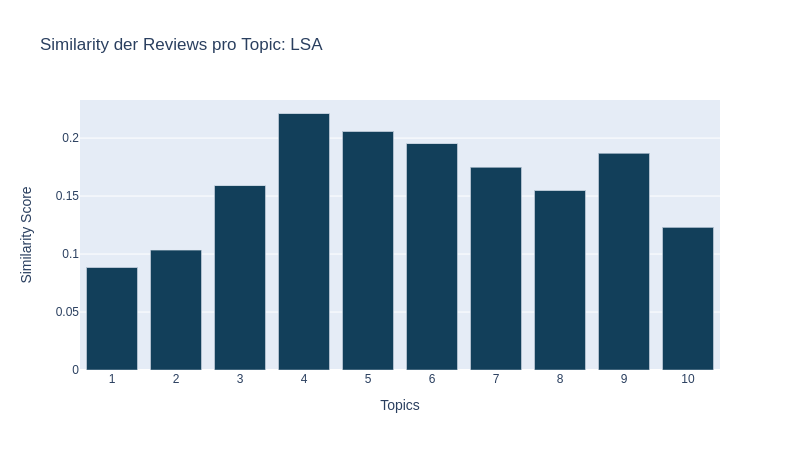

In [19]:
# Graphische Darstellung
similarity_fig = px.bar(similarity_df, x="Topic_number", y="Similarity", title="Similarity der Reviews pro Topic: LSA",
                        color_discrete_sequence=px.colors.sequential.Darkmint_r)

# Update Layout
similarity_fig.update_xaxes(title_text= "Topics")
similarity_fig.update_yaxes(title_text= "Similarity Score")

# Speichern in ein HTML File
similarity_fig.write_html("LSA_Similarity_per_Topic.html")

# Ausgabe
gitly.show(similarity_fig)

####__Topic Similarity Matrix__

Mithilfe der Topic Similarity Matrix lassen sich ähnliche Topics identifizieren, welche sich mit ähnlichen Inhalten befassen. Die Abbildung wurde in Anlehnung an die "Topic Similarity Matrix" von BERTopic erstellt. Für die Ermittlung des Cosine Similarity Scores werden die Vektoren der Topics miteinander verglichen (Grootendorst, Heatmap, 2023). Die Diagonale bildet den Similarity Score des Topics ab, welches bereits im Schritt zuvor berechnet wurde.

In [20]:
# Erstellen der Topic Similarity Matrix
# Erstellen einer leeren Matrix
matrix_for_heat_map = np.zeros((10,10))

# Transformation des NumPy arrays zu einer Liste für schnelleren Loop
topics_unique = list(topics_unique)

# Loop über die Spalten und Zeilen zur Befüllung der Matrix
for col in range(len(topics_unique)):
  for row in range(len(topics_unique)):
    # Errechnung des durchschnittlichen Simiarity Scores
    similarity_between_topics = cosine_similarity(vector_dict[str(topics_unique[col])],
                                                  vector_dict[str(topics_unique[row])]).mean()
    # Hinzufügen des Scores in die Matrix
    matrix_for_heat_map[row,col] = similarity_between_topics

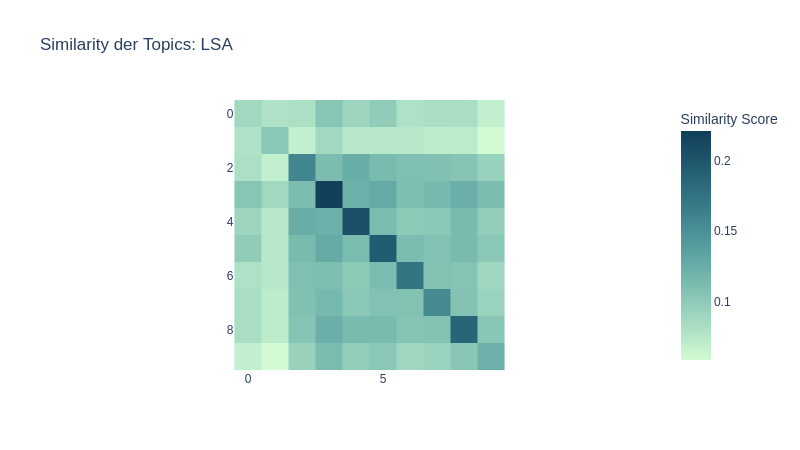

In [22]:
# Graphische Darstellung
similarity_topics_fig = px.imshow(matrix_for_heat_map, title="Similarity der Topics: LSA",
                                  labels=dict(color="Similarity Score"),
                                  width= 600,
                                  color_continuous_scale=px.colors.sequential.Darkmint)

# Speichern in ein HTML File
similarity_topics_fig.write_html("LSA_Similarity_between_Topic.html")

# Ausgabe
gitly.show(similarity_topics_fig)

#### __Intertopic Distanz der Topics__

Mithilfe der Intertopic Distanz Map lässt sich die Entfernung zwischen den Themen messen. Je ähnlicher sich die Themen sind, desto näher liegen diese beieinander und können sich sogar überlappen, falls diese teilweise identische Inhalte aufweisen. Je weiter die Blasen in dem Diagramm voneinander entfernt sind, desto mehr unterscheiden sich die Themen voneinander. Die Größe der Kreise repräsentieren die Anzahl der im Topic enthaltenen Reviews (Amy, 2022). Während andere Modelle, wie BERTooic oder LDA eine derartige Darstellung standardmäßig implementiert haben, wurde für LSA eine vergleichbare Darstellung manuell erstellt. Die Logik orientiert sich an den Berechnungen von BERTopic (Grootendorst, Topics, 2023).

In [21]:
# Erstellen der Intertopic Distanz Map (Inspiriert von BERTopic)
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/topics.html#bertopic.plotting._topics.visualize_topics
# Speichern der Vektoren in einer Liste
embeddings = documents_df.Vector.values.tolist()

# Auf eine Zweidimensionale Ebene bringen
embeddings_2D = UMAP(n_neighbors=2, n_components=2, metric='cosine', random_state=42).fit_transform(embeddings)

# Hinzufügen der Spalten in den DataFrame "documents_df"
documents_df = documents_df.assign(x=embeddings_2D[:, 0], y=embeddings_2D[:, 1])

In [23]:
# Gruppieren nach 'Topic_number' und Aggregation der x und y Vektoren
frequency_df = documents_df.groupby('Topic_number').agg(count=('Topic_number', 'count'),
                                                        x_mean=('x', 'mean'),
                                                        y_mean=('y', 'mean')).reset_index()

# Konvertieren der Topic_number in das richtige Format
frequency_df["Topic_number"] = frequency_df["Topic_number"].astype(str)

# Ergänzen um die Namen der Topics und deren Wahrscheinlichkeiten
frequency_df = frequency_df.merge(topics_df, on="Topic_number", how="left")

# Löschen nicht relevanter Informationen
frequency_df.drop(["Sigma"], axis=1, inplace=True)

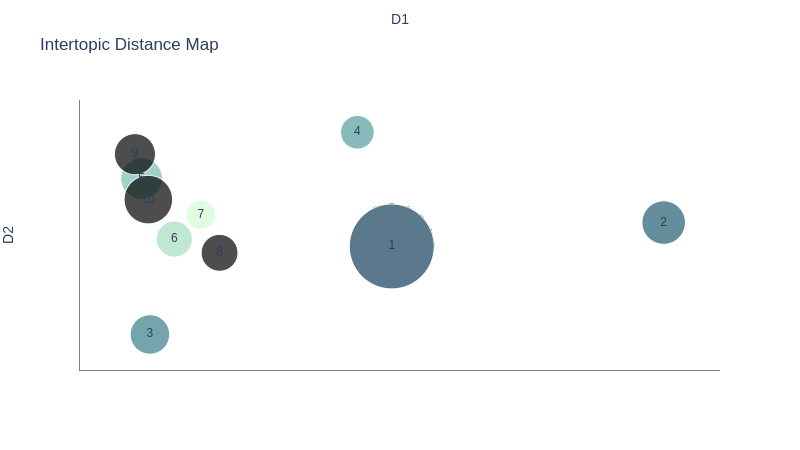

In [30]:
# Graphische Darstellung
intertopic_distanz_fig = px.scatter(frequency_df, x="x_mean", y="y_mean",
                                    size = "count",
                                    hover_name = "Words",
                                    text="Topic_number",
                                    height= 600,
                                    width= 600,
                                    size_max = 60,
                                    title = "Intertopic Distance Map")

# Layout updaten
intertopic_distanz_fig.update_traces(marker=dict(color=px.colors.sequential.Darkmint_r))
intertopic_distanz_fig.update_layout(plot_bgcolor="white",
                                     paper_bgcolor="white",
                                     showlegend=False)

# x- und y-Achse Updaten
intertopic_distanz_fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', showticklabels=False, title= "D1")
intertopic_distanz_fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', showticklabels=False, title= "D2")

# Speichern in ein HTML File
intertopic_distanz_fig.write_html("LSA_Intertopic_Distance_Map.html")

# Ausgabe
gitly.show(intertopic_distanz_fig)

#### __Hierarchisches Clustering__

Mithilfe dieser Visualisierungsform, lassen sich die  hierarchische Struktur der Topics visualisieren. Auf diese Weise lassen sich die Inhaltlichen Beziehungen von Themen identifizieren, welche miteinander Verbunden sind. Des weiteren werden Themengruppen erseichtlich sowie eine Strukturierung in Unter- und Überthemen. In Anlehnung an BERTopic wurde hierfür eine Ward-Linkage-Funktion von Plotly erstellt, welche die hierarchische Clusterbildung auf Basis der bereits berechneten Kosinus-Similarity-Distanzmatrix der Topics abbildet (Grootendorst, Hierarchy, 2023).

In [25]:
# Umwandeln der Topic Embeddings in ein 2 dimensionales Array
embeddings_array = frequency_df[['x_mean','y_mean']].to_numpy()

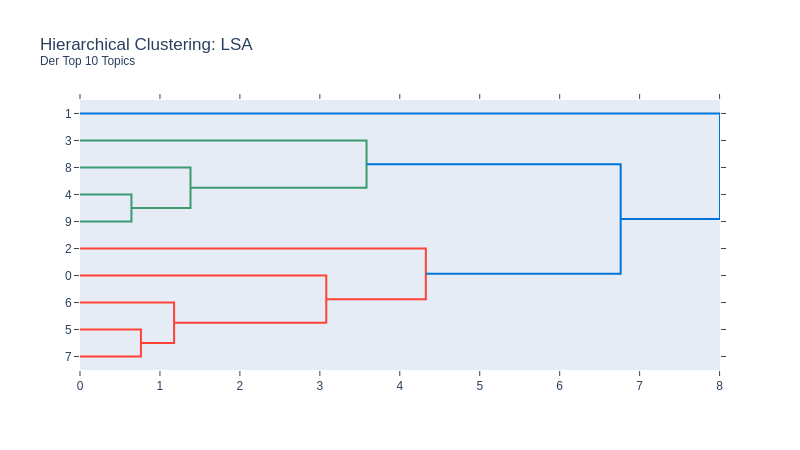

In [44]:
# Graphische Darstellung
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/hierarchy.html#bertopic.plotting._hierarchy.visualize_hierarchy
# Quelle: https://plotly.com/python/dendrogram/
hierarchical_topics_fig = ff.create_dendrogram(embeddings_array,
                                               orientation="left")

# Update Laout
hierarchical_topics_fig.update_layout(title= "Hierarchical Clustering: LSA <br><sup>Der Top 10 Topics</sup>")

# Speichern in einem HTML File
hierarchical_topics_fig.write_html("LSA_Hierachical_Clustering_Top10.html")

# Ausgabe
gitly.show(hierarchical_topics_fig)

## 6. Literaturverzeichnis

Amy. (21. 10 2022). Topic Modeling with Deep Learning Using Python BERTopic. Abgerufen am 05. 08 2023 von medium.com: https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504

Campagnola, C. (18. 05 2020). Perplexity in Language Models. Abgerufen am 24. 07 2023 von towardsdatascience.com: https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

Grootendorst, M. (2023). Heatmap. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/heatmap.html#bertopic.plotting._heatmap.visualize_heatmap

Grootendorst, M. (2023). Hierarchy. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/hierarchy.html

Grootendorst, M. (2023). Topics. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/topics.html

Ioana. (10. 05 2020). Latent Semantic Analysis: intuition, math, implementation. Abgerufen am 24. 04 2023 von towardsdatascience.com: https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8

Kapadia, S. (19. 08 2019). Evaluate Topic Models: Latent Dirichlet Allocation (LDA). Abgerufen am 21. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

MEHROTRA, R. (2022). Topic Modelling using LDA and LSA in Sklearn. Abgerufen am 25. 07 2023 von www.kaggle.com: https://www.kaggle.com/code/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn

Pascual, F. (26. 09 2019). Topic Modeling: An Introduction. Abgerufen am 13. 12 2022 von monkeylearn.com: https://monkeylearn.com/blog/introduction-to-topic-modeling/

pawangfg. (11. 07 2023). Singular Value Decomposition (SVD). Abgerufen am 27. 07 2023 von www.geeksforgeeks.org: https://www.geeksforgeeks.org/singular-value-decomposition-svd/

Pedro, J. (10. 01 2022). Understanding Topic Coherence Measures. Abgerufen am 23. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

Rüdiger, M., Antons, D., Joshi, A. M., & Salge, T.-O. (28. 04 2022). Topic modeling revisited: New evidence on algorithm performance and quality metrics. Abgerufen am 13. 06 2023 von journals.plos.org: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0266325

Sitikhu, P., Pahi, K., Thapa, P., & Shakya, S. (31. 10 2019). A Comparison of Semantic Similarity Methods for Maximum Human Interpretability. Abgerufen am 05. 08 2023 von Department of Electronics and Computer Engineering, Tribhuwan University: https://arxiv.org/pdf/1910.09129.pdf

Supe, K. (07. 06 2023). Understanding Cosine Similarity in Python with Scikit-Learn. Abgerufen am 05. 08 2023 von memgraph.com/: https://memgraph.com/blog/cosine-similarity-python-scikit-learn